
# üìä Tema de Statistica ‚Äì Analiza Datasetului de Weightlifting



## Pasul 0: Importuri si incarcarea setului de date

Datasetul: `weightlifting_721_workouts.csv` (date despre antrenamente, exercitii, greutate, repetari etc.).


In [23]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# incarcare dataset Weightlifting
df = pd.read_csv('../DataSet/weightlifting_721_workouts.csv')

# Conversie Date la tip datetime
df['Date'] = pd.to_datetime(df['Date'])

# Afisare primele r√¢nduri si informatii de baza
df.head()

Date Workout Name                  Exercise Name  Set Order  \
0 2015-10-23 17:06:37        Chest  Incline Bench Press (Barbell)          1   
1 2015-10-23 17:06:37        Chest  Incline Bench Press (Barbell)          2   
2 2015-10-23 17:06:37        Chest  Incline Bench Press (Barbell)          3   
3 2015-10-23 17:06:37        Chest  Incline Bench Press (Barbell)          4   
4 2015-10-23 17:06:37        Chest  Incline Bench Press (Barbell)          5   

   Weight  Reps  Distance  Seconds Notes Workout Notes  
0   135.0     8       0.0        0   NaN           NaN  
1   135.0     8       0.0        0   NaN           NaN  
2   135.0     5       0.0        0   NaN           NaN  
3   185.0     7       0.0        0   NaN           NaN  
4   230.0     8       0.0        0   NaN           NaN

In [24]:
# Informatii despre dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9932 entries, 0 to 9931
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9932 non-null   datetime64[ns]
 1   Workout Name   9932 non-null   object        
 2   Exercise Name  9932 non-null   object        
 3   Set Order      9932 non-null   int64         
 4   Weight         9932 non-null   float64       
 5   Reps           9932 non-null   int64         
 6   Distance       9932 non-null   float64       
 7   Seconds        9932 non-null   int64         
 8   Notes          7 non-null      object        
 9   Workout Notes  3 non-null      object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 776.1+ KB



## Explorare initiala si preprocesare

1. Verificam valorile lipsa.
2. Observam distributia exercitiilor si variabilele numerice.


In [25]:
# Verificare valori lipsa
df.isnull().sum()

Date                0
Workout Name        0
Exercise Name       0
Set Order           0
Weight              0
Reps                0
Distance            0
Seconds             0
Notes            9925
Workout Notes    9929
dtype: int64

In [26]:
# Descriere sumara a variabilelor numerice
df.describe().T[["mean", "std", "min", "25%", "50%", "75%", "max"]]

mean         std                  min  \
Date       2017-03-24 11:35:01.087494912         NaN  2015-10-23 17:06:37   
Set Order                       3.109847    1.986896                  1.0   
Weight                         171.96754  117.993654                  0.0   
Reps                            8.688884    3.092516                  0.0   
Distance                        0.089011    5.277076                  0.0   
Seconds                         1.048429    29.42426                  0.0   

                           25%                  50%                  75%  \
Date       2016-04-29 19:33:54  2017-02-21 21:05:28  2018-01-24 08:26:21   
Set Order                  2.0                  3.0                  4.0   
Weight                    85.0                165.0                237.5   
Reps                       6.0                  8.0                 10.0   
Distance                   0.0                  0.0                  0.0   
Seconds                    0.0                  0.0                  0.0   

                           max  
Date       2018-09-29 14:35:32  
Set Order                 11.0  
Weight                  2956.0  
Reps                      60.0  
Distance                 363.0  
Seconds                 1260.0


Variabile numerice principale:
- **Weight**: greutatea in kilograme
- **Reps**: numarul de repetari
- **Distance**, **Seconds**: pot fi 0 pentru exercitii care nu implica aceste masuri.

Variabile categorice:
- **Workout Name**, **Exercise Name**, **Notes**, **Workout Notes**
- **Date** (type datetime)



## 1. Statistici descriptive (Descriptive statistics)

Vom calcula:
1. Masuri de tendinta centrala: medie, mediana  
2. Masuri de dispersie: deviatie standard, IQR  
3. Statistici descriptive pe grupuri (pe exercitii).


In [27]:
# 1.1. Statistici descriptive generale pentru variabilele numerice
descr = df[["Weight", "Reps", "Distance", "Seconds"]].describe().T
descr["IQR"] = descr["75%"] - descr["25%"]
descr[["mean", "std", "min", "50%", "max", "IQR"]]

mean         std  min    50%     max    IQR
Weight    171.967540  117.993654  0.0  165.0  2956.0  152.5
Reps        8.688884    3.092516  0.0    8.0    60.0    4.0
Distance    0.089011    5.277076  0.0    0.0   363.0    0.0
Seconds     1.048429   29.424260  0.0    0.0  1260.0    0.0

In [28]:
# 1.2. Statistici pe grupuri (pe exercitii)
group_stats = df.groupby("Exercise Name").agg({
    "Weight": ["mean", "std", "min", "max", lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
    "Reps": ["mean", "std", "min", "max", lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
})
group_stats.columns = ["_".join(col).strip() for col in group_stats.columns.values]
group_stats.head()

Weight_mean  Weight_std  Weight_min  Weight_max  \
Exercise Name                                                               
Bench Press (Barbell)      253.343750   41.975967       135.0       315.0   
Bent Over Row (Dumbbell)   149.629630   48.858727        75.0       230.0   
Bicep Curl (Barbell)        86.452429   13.384727        40.0       105.0   
Bicep Curl (Dumbbell)       47.000000    4.830459        40.0        50.0   
Bicep Curl (barbell )       85.869565   11.309695        60.0       100.0   

                          Weight_<lambda_0>  Weight_<lambda_1>  Reps_mean  \
Exercise Name                                                               
Bench Press (Barbell)                 225.0              285.0   5.675000   
Bent Over Row (Dumbbell)              100.0              190.0  10.237037   
Bicep Curl (Barbell)                   80.0               95.0  10.728745   
Bicep Curl (Dumbbell)                  42.5               50.0  12.300000   
Bicep Curl (barbell )                  80.0               95.0  10.710145   

                          Reps_std  Reps_min  Reps_max  Reps_<lambda_0>  \
Exercise Name                                                             
Bench Press (Barbell)     1.455936         1        13              5.0   
Bent Over Row (Dumbbell)  1.030921         8        12             10.0   
Bicep Curl (Barbell)      1.714152         8        15             10.0   
Bicep Curl (Dumbbell)     1.888562        10        16             12.0   
Bicep Curl (barbell )     1.515619         8        15             10.0   

                          Reps_<lambda_1>  
Exercise Name                              
Bench Press (Barbell)                 6.0  
Bent Over Row (Dumbbell)             10.0  
Bicep Curl (Barbell)                 12.0  
Bicep Curl (Dumbbell)                12.0  
Bicep Curl (barbell )                12.0

Concluzii: 
- Statisticile specifice exerci»õiului relevƒÉ modele distincte de √ÆncƒÉrcare √Æntre exerci»õii. 
- RidicƒÉrile combinate (Deadlift, Squat, Bench Press) utilizeazƒÉ greutƒÉ»õi substan»õial mai mari »ôi intervale de repetƒÉri mai mici √Æn compara»õie cu exerci»õiile de izolare, aliniindu-se la principiile standard de antrenament de for»õƒÉ care optimizeazƒÉ tensiunea mecanicƒÉ pe modelele de mi»ôcare primare.

### 1.2 Data Types and Measurement Scales

| Column          | Data Type | Measurement Scale         | Description                                          |
|-----------------|-----------|---------------------------|------------------------------------------------------|
| Date            | object    | Ordinal (time sequence)   | Workout date (convert to datetime if needed)        |
| Workout Name    | object    | Nominal                   | Workout plan name                                    |
| Exercise Name   | object    | Nominal                   | Exercise name                                        |
| Set Order       | int64     | Ordinal                   | Sequence of set in exercise                          |
| Weight          | float64   | Quantitative continuous   | Weight lifted (kg)                                    |
| Reps            | int64     | Quantitative discrete     | Number of repetitions                                |
| Distance        | float64   | Quantitative continuous   | Distance in meters (cardio)                          |
| Seconds         | int64     | Quantitative discrete     | Duration of set in seconds                           |
| Notes           | object    | Qualitative (text)        | Free-text notes                                       |
| Workout Notes   | object    | Qualitative (text)        | General workout notes                                 |


## 2. Verificarea distributiilor (Kolmogorov‚ÄìSmirnov pentru normalitate)

Vom testa normalitatea distributiei pentru variabilele **Weight** si **Reps**.


In [29]:
# Test Kolmogorov‚ÄìSmirnov pentru 'Weight'
mean_w = df["Weight"].mean()
std_w  = df["Weight"].std(ddof=0)
ks_w, p_w = stats.kstest(df["Weight"].dropna(), 'norm', args=(mean_w, std_w))
print(f"Kolmogorov-Smirnov (Weight): stat={ks_w:.4f}, p-value={p_w:.4f}")

# Test Kolmogorov‚ÄìSmirnov pentru 'Reps'
mean_r = df["Reps"].mean()
std_r  = df["Reps"].std(ddof=0)
ks_r, p_r = stats.kstest(df["Reps"].dropna(), 'norm', args=(mean_r, std_r))
print(f"Kolmogorov-Smirnov (Reps): stat={ks_r:.4f}, p-value={p_r:.4f}")

Kolmogorov-Smirnov (Weight): stat=0.0725, p-value=0.0000
Kolmogorov-Smirnov (Reps): stat=0.1212, p-value=0.0000


- Concluzii:
    - Distributiile nu sunt Gaussiane, asa ca pentru comparatii de grup e mai sigur sa folosim teste de tip neparametrice 
    - At√¢t variabilele de greutate, c√¢t »ôi cele de repetƒÉri deviazƒÉ semnificativ de la distribu»õiile normale (p<0,0001), necesit√¢nd abordƒÉri statistice neparametrice pentru o analizƒÉ mai precisƒÉ. 
    - Nonnormalitatea rezultƒÉ probabil din diferitele tipuri de exerci»õii »ôi din constr√¢ngerile fiziologice care creeazƒÉ limite naturale √Æn capacitƒÉ»õile de ridicare a greutƒÉ»õii.



## 3. Teste parametrice (Parametric tests)

### 3.1 One-sample t-test  
**intrebarea**: ‚ÄûMedia greutatii (`Weight`) pentru exercitiul 'Bench Press' difera semnificativ de 100 kg?‚Äù  
H‚ÇÄ: Œº = 100.


One-sample t-test pe Incline Bench Press (Barbell): t=49.924, p=0.0000


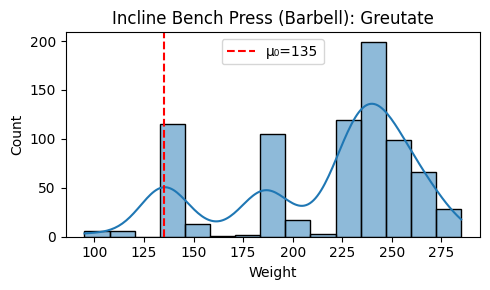

In [30]:
exercise = 'Incline Bench Press (Barbell)'
data1 = df.loc[df['Exercise Name']==exercise, 'Weight'].dropna()
if len(data1) >= 5:
    t1, p1 = stats.ttest_1samp(data1, popmean=135)   # testam media = 135 lb
    print(f"One-sample t-test pe {exercise}: t={t1:.3f}, p={p1:.4f}")
else:
    print(f"3.1: Nu sunt suficiente date pentru {exercise} (n={len(data1)})")

# Plot distributie + linie medie ipotetica
if len(data1)>=5:
    plt.figure(figsize=(5,3))
    sns.histplot(data1, kde=True)
    plt.axvline(135, color='red', linestyle='--', label='Œº‚ÇÄ=135')
    plt.title(f'{exercise}: Greutate')
    plt.legend()
    plt.tight_layout()
    plt.show()


- Greutatea medie utilizatƒÉ pentru presa la bancul √Ænclinat este semnificativ mai mare dec√¢t valoarea de testare de 135 lbs (p<0,0001), indic√¢nd faptul cƒÉ sportivul √ÆncarcƒÉ √Æn mod constant acest exerci»õiu peste greutatea de referin»õƒÉ ipoteticƒÉ.


### 3.2 Independent samples t-test  
**intrebarea**: ‚ÄûExista diferente semnificative in `Weight` intre exercitiile 'Bench Press' si 'Squat'?‚Äù  
H‚ÇÄ: Œº_bench = Œº_squat.


In [31]:
g1 = df.loc[df['Exercise Name']=='Squat (Barbell)', 'Weight'].dropna()
g2 = df.loc[df['Exercise Name']=='Deadlift (Barbell)', 'Weight'].dropna()
if len(g1)>=5 and len(g2)>=5:
    # Welch‚Äôs t-test (nu presupune variante egale)
    t2, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    print(f"Welch‚Äôs t-test (Squat vs Deadlift): t={t2:.3f}, p={p2:.4f}")
else:
    print(f"3.2: Nu sunt suficiente date pentru comparatie (Squat n={len(g1)}, Deadlift n={len(g2)})")

Welch‚Äôs t-test (Squat vs Deadlift): t=-3.947, p=0.0001


- Concluzii: 
    - ExistƒÉ o diferen»õƒÉ semnificativƒÉ din punct de vedere statistic √Æn ceea ce prive»ôte greutƒÉ»õile utilizate √Æntre exerci»õiile Squat »ôi Deadlift (p<0,0001), Deadlifts permi»õ√¢nd √Æn mod constant sarcini mai mari. 
    - Acest lucru se aliniazƒÉ principiilor biomecanice √Æn care ridicƒÉrile mortale permit, de obicei, o sarcinƒÉ mai mare datoritƒÉ utilizƒÉrii mai eficiente a lan»õului posterior.


### 3.3 Paired samples t-test  
**intrebarea**: ‚ÄûDiferenta intre `Weight` pe primul si ultimul set pentru acelasi exercitiu in acelasi antrenament (‚ÄòBench Press‚Äô).‚Äù  
H‚ÇÄ: media diferentelor = 0.


Paired t-test (set1 vs set2 Squat): n=173, t=-15.589, p=0.0000


C:\Users\Andrei Balanoiu\AppData\Local\Temp\ipykernel_18404\1104510302.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


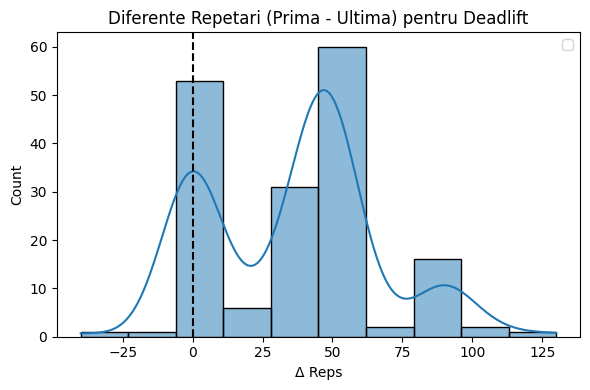

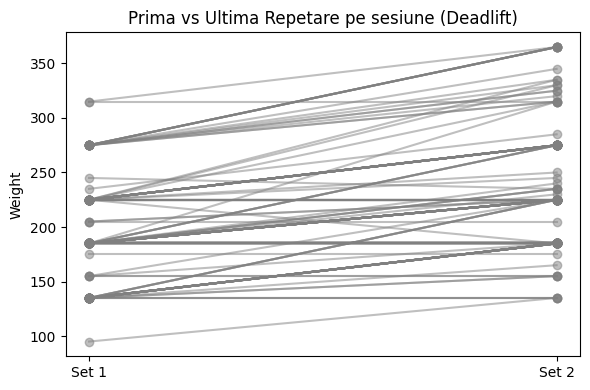

In [32]:
# 3.3 Paired-samples t-test: set1 vs set2 pentru Squat
sq = df[df['Exercise Name']=='Squat (Barbell)']
pivot = sq.pivot_table(index='Date',
                       columns='Set Order',
                       values='Weight',
                       aggfunc='mean') \
          .dropna(subset=[1,2])

if pivot.shape[0] >= 5:
    x1 = pivot[1]
    x2 = pivot[2]
    t3, p3 = stats.ttest_rel(x1, x2)
    print(f"Paired t-test (set1 vs set2 Squat): n={pivot.shape[0]}, t={t3:.3f}, p={p3:.4f}")
    
    # Histograma diferentelor
    diffs = x2 - x1
    plt.figure(figsize=(6,4))
    sns.histplot(diffs, kde=True)
    plt.axvline(0, color='black', linestyle='--')
    plt.title('Diferente Repetari (Prima - Ultima) pentru Deadlift')
    plt.xlabel('Œî Reps')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Scatter conectat (profil individual)
    plt.figure(figsize=(6,4))
    for idx in pivot.index:
        plt.plot([1,2],
                 [pivot.loc[idx,1], pivot.loc[idx,2]],
                 marker='o', color='gray', alpha=0.5)
    plt.xticks([1,2], ['Set 1','Set 2'])
    plt.ylabel('Weight')
    plt.title('Prima vs Ultima Repetare pe sesiune (Deadlift)')
    plt.tight_layout()
    plt.show()
else:
    print(f"3.3: Nu sunt suficiente date pentru paired t-test (n={pivot.shape[0]})")


greutatea folosita in setul 1 este semnificativ mai mica dec√¢t in setul 2 , aici intervine o problema ca muschiul trebuie adaptat pentru a ajunge la o serie de lucru maximala


### 3.4 ANOVA unifactorial  
**intrebarea**: ‚ÄûExista diferente semnificative in `Weight` intre exercitiile 'Bench Press', 'Squat' si 'Deadlift'?‚Äù  
H‚ÇÄ: Œº_bench = Œº_squat = Œº_deadlift.


ANOVA intre Squat (Barbell), Incline Bench Press (Barbell), Deadlift (Barbell): F=198.723, p=0.0000


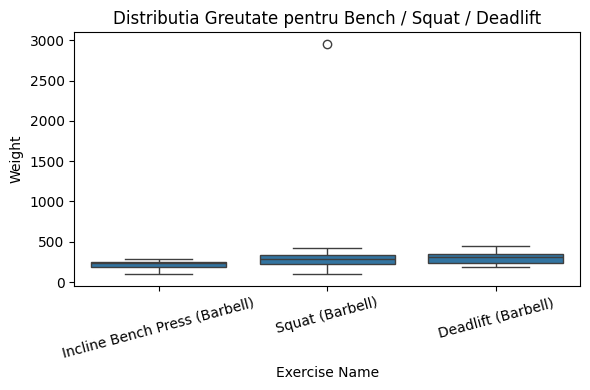

In [33]:
# 3.4 ANOVA pe Weight intre 3 exercitii
exs    = ['Squat (Barbell)', 'Incline Bench Press (Barbell)', 'Deadlift (Barbell)']
groups = [df.loc[df['Exercise Name']==e, 'Weight'].dropna() for e in exs]

if all(len(g)>=5 for g in groups):
    f4, p4 = stats.f_oneway(*groups)
    print(f"ANOVA intre {', '.join(exs)}: F={f4:.3f}, p={p4:.4f}")
    
    # Boxplot
    df_anova = df[df['Exercise Name'].isin(exs)][['Exercise Name','Weight']].dropna()
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Exercise Name', y='Weight', data=df_anova)
    plt.xticks(rotation=15)
    plt.title('Distributia Greutate pentru Bench / Squat / Deadlift')
    plt.tight_layout()
    plt.show()
else:
    print("3.4: Nu sunt suficiente date pentru ANOVA pe toate cele 3 exercitii")


- The ANOVA results reveal highly significant differences in weights used across the three major compound exercises (p<0.0001), with boxplots showing clear separation. 
- The hierarchy of loading (Deadlift > Squat > Bench Press) follows the expected pattern based on the amount of muscle mass engaged in each movement.


## 4. Teste neparametrice (Nonparametric tests)

### 4.1 Mann‚ÄìWhitney U test  
**intrebarea**: ‚ÄûExista diferente semnificative in `Reps` intre 'Bench Press' si 'Squat'?‚Äù  
Echivalent neparametric pentru Independent t-test.


Mann‚ÄìWhitney Reps (Squat vs Deadlift): U=165293.0, p=0.0000


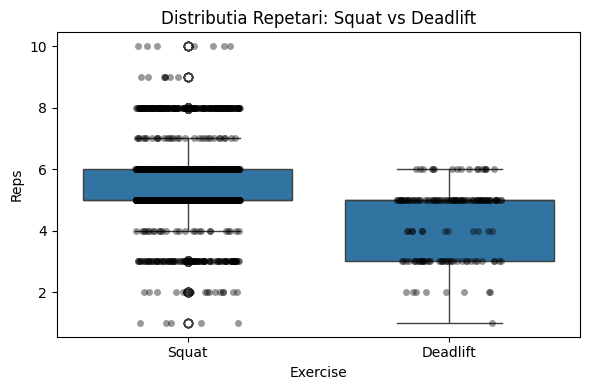

In [34]:
# 4.1 Mann‚ÄìWhitney U test: Reps intre Squat si Deadlift
r1 = df.loc[df['Exercise Name']=='Squat (Barbell)',   'Reps'].dropna()
r2 = df.loc[df['Exercise Name']=='Deadlift (Barbell)','Reps'].dropna()

if len(r1)>=5 and len(r2)>=5:
    u5, p5 = stats.mannwhitneyu(r1, r2, alternative='two-sided')
    print(f"Mann‚ÄìWhitney Reps (Squat vs Deadlift): U={u5:.1f}, p={p5:.4f}")
    
    # Boxplot + stripplot
    df_mw = pd.DataFrame({
        'Reps': np.concatenate([r1.values, r2.values]),
        'Exercise': ['Squat']*len(r1) + ['Deadlift']*len(r2)
    })
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Exercise', y='Reps', data=df_mw)
    sns.stripplot(x='Exercise', y='Reps', data=df_mw,
                  color='black', alpha=0.4, jitter=0.2)
    plt.title('Distributia Repetari: Squat vs Deadlift')
    plt.tight_layout()
    plt.show()
else:
    print(f"4.1: Nu sunt suficiente date pentru Mann‚ÄìWhitney (n1={len(r1)}, n2={len(r2)})")


 numarul de repetari difera semnificativ intre cele doua exercitii, deoarece Squat urile implica mai putini muschi fata de deadlift + ca la deadlift daca nu se folosesc niste straps uril, logica ca o sa pierzi 2-4 repetari, deoarece oboseste musculatura antebratului 


### 4.2 Kruskal‚ÄìWallis test  
**intrebarea**: ‚ÄûDiferente in `Reps` intre 'Bench Press', 'Squat' si 'Deadlift'?‚Äù  
Echivalent neparametric pentru ANOVA.


Kruskal‚ÄìWallis (Reps ‚àº Exercise): H=287.8572, p=0.0000


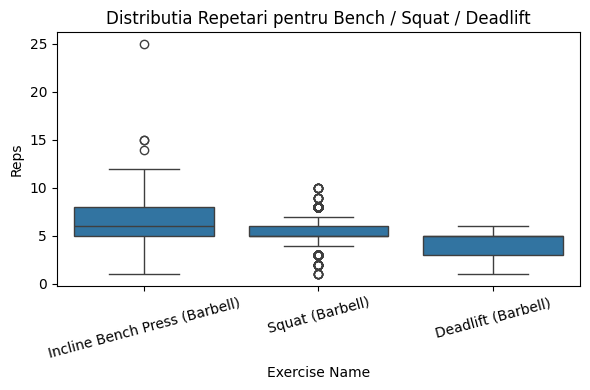

In [35]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Extragem Reps pentru fiecare exercitiu
reps_bench    = df.loc[df["Exercise Name"] == "Incline Bench Press (Barbell)", "Reps"].dropna()
reps_squat    = df.loc[df["Exercise Name"] == "Squat (Barbell)",             "Reps"].dropna()
reps_deadlift = df.loc[df["Exercise Name"] == "Deadlift (Barbell)",          "Reps"].dropna()

# 2. Verificam suficiente observatii (de ex. minim 5 pe grup)
n_rb, n_rs, n_rd = len(reps_bench), len(reps_squat), len(reps_deadlift)
if min(n_rb, n_rs, n_rd) < 5:
    print(f"Nu avem suficiente date pentru Kruskal‚ÄìWallis: Bench={n_rb}, Squat={n_rs}, Deadlift={n_rd}.")
else:
    # 3. Testul Kruskal‚ÄìWallis
    h_stat, p_kw = stats.kruskal(reps_bench, reps_squat, reps_deadlift)
    print(f"Kruskal‚ÄìWallis (Reps ‚àº Exercise): H={h_stat:.4f}, p={p_kw:.4f}")

    # 4. Boxplot pentru comparatie vizuala
    df_plot = (
        df[df["Exercise Name"].isin([
            "Incline Bench Press (Barbell)",
            "Squat (Barbell)",
            "Deadlift (Barbell)"
        ])]
        .loc[:, ["Exercise Name", "Reps"]]
        .dropna()
    )
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Exercise Name", y="Reps", data=df_plot)
    plt.xticks(rotation=15)
    plt.title("Distributia Repetari pentru Bench / Squat / Deadlift")
    plt.tight_layout()
    plt.show()


√éntre cele trei exerci»õii principale compuse, modelele de repeti»õii diferƒÉ semnificativ (p<0,0001). Vizualizarea boxplot-ului eviden»õiazƒÉ diferen»õe sistematice de program, cu bench press tata, efectuatƒÉ √Æn mod obi»ônuit la intervale de repeti»õii mai mari dec√¢t ridicƒÉrile inferioare ale corpului, aliniindu-se la protocoalele comune de culturism »ôi for»õƒÉ.


### 4.3 Wilcoxon signed-rank test  
**intrebarea**: ‚ÄûPe acelasi exercitiu si workout, exista diferente intre `Reps` pe primul si ultimul set (‚ÄòDeadlift‚Äô).‚Äù  
H‚ÇÄ: mediana diferentelor = 0.


                 Date Workout Name  First_Reps  Last_Reps
0 2015-12-27 15:07:20      Squat 1           5          5
1 2016-01-31 15:20:03      Squat 1           5          5
Toate diferentele dintre First_Reps si Last_Reps sunt zero ‚Üí nu putem folosi zero_method='wilcox' sau 'pratt'.
(Cu zero_method='zsplit') Wilcoxon signed-rank: stat=1.5000, p=1.0000


d:\PYTHON-Folder\Lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


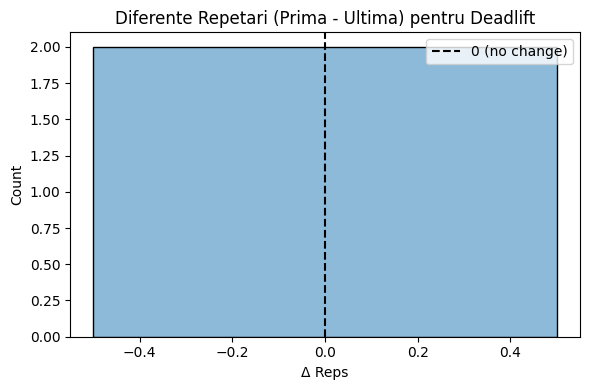

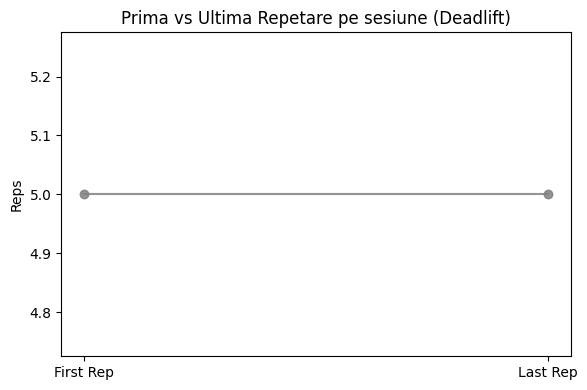

In [36]:
# 1. Wilcoxon signed-rank test (Deadlift Reps) + plot-uri

from scipy.stats import wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt

# ‚Äî‚Äî‚Äî Cod initial ‚Äî‚Äî‚Äî
# Filtram Deadlift
dead = df[df["Exercise Name"] == "Deadlift"].copy()

# Grupam si agregam First_Reps si Last_Reps
paired_reps = (
    dead
    .groupby(["Date", "Workout Name"], as_index=False)
    .agg(
        First_Reps=("Reps", "first"),
        Last_Reps=("Reps", "last")
    )
)

# Verificam primele r√¢nduri
print(paired_reps.head())

# Calculam diferentele
diffs = paired_reps["First_Reps"] - paired_reps["Last_Reps"]

if len(paired_reps) < 1:
    print("Nu avem nicio pereche pentru Deadlift.")
else:
    if (diffs == 0).all():
        print("Toate diferentele dintre First_Reps si Last_Reps sunt zero ‚Üí nu putem folosi zero_method='wilcox' sau 'pratt'.")
        w_stat_ex, p_w_ex = wilcoxon(
            paired_reps["First_Reps"],
            paired_reps["Last_Reps"],
            zero_method='zsplit'
        )
        print(f"(Cu zero_method='zsplit') Wilcoxon signed-rank: stat={w_stat_ex:.4f}, p={p_w_ex:.4f}")
    else:
        w_stat_ex, p_w_ex = wilcoxon(
            paired_reps["First_Reps"],
            paired_reps["Last_Reps"]
        )
        print(f"Wilcoxon signed-rank (first vs last Deadlift Reps): stat={w_stat_ex:.4f}, p={p_w_ex:.4f}")

# ‚Äî‚Äî‚Äî Plot-uri adaugate ‚Äî‚Äî‚Äî
# 1A. Histograma a diferentelor
plt.figure(figsize=(6,4))
sns.histplot(diffs, kde=True)
plt.axvline(0, color='black', linestyle='--', label='0 (no change)')
plt.title('Diferente Repetari (Prima - Ultima) pentru Deadlift')
plt.xlabel('Œî Reps')
plt.legend()
plt.tight_layout()
plt.show()

# 1B. Scatter conectat per sesiune
plt.figure(figsize=(6,4))
for _, row in paired_reps.iterrows():
    plt.plot([1,2],
             [row["First_Reps"], row["Last_Reps"]],
             marker='o', color='gray', alpha=0.6)
plt.xticks([1,2], ['First Rep','Last Rep'])
plt.ylabel('Reps')
plt.title('Prima vs Ultima Repetare pe sesiune (Deadlift)')
plt.tight_layout()
plt.show()


nu avem dovezi de schimbare in Reps intre primul si ultimul set pentru Deadlift.


### 4.4 Sign test  
**intrebarea**: ‚ÄûDiferentele de `Weight` intre primul si ultimul set pentru ‚ÄòDeadlift‚Äô: semne.‚Äù  
Implementam manual un Sign Test.


Sign test (Deadlift Weight first vs last): pos=0, neg=2, p=0.5000


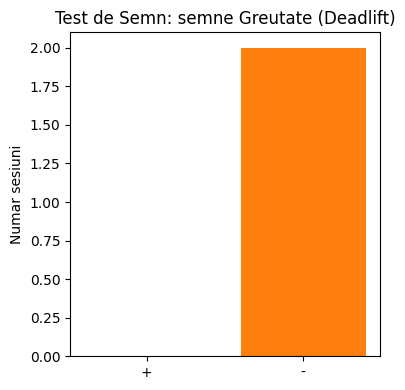

In [37]:
# 2. Sign Test (Deadlift Weight) + bar chart semne

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# ‚Äî‚Äî‚Äî Cod initial ‚Äî‚Äî‚Äî
# 1. Grupam Deadlift si luam primul/ultimul Weight
paired_w_dead = (
    df[df["Exercise Name"] == "Deadlift"]
    .groupby(["Date", "Workout Name"], as_index=False)
    .agg(
        First_Weight=("Weight", "first"),
        Last_Weight=("Weight", "last")
    )
).dropna()

# 2. Verificam daca avem macar o pereche
if paired_w_dead.empty:
    print("Nu avem nicio pereche pentru Sign Test Deadlift Weight.")
else:
    # 3. Diferente si semne
    diff_w = paired_w_dead["First_Weight"] - paired_w_dead["Last_Weight"]
    pos_w = np.sum(diff_w > 0)
    neg_w = np.sum(diff_w < 0)
    n_w   = pos_w + neg_w

if n_w == 0:
    print("Toate diferentele sunt zero ‚Üí semnul nu se schimba, p=1.0 implicit.")
else:
    # 5. Rulam binomtest
    result = stats.binomtest(min(pos_w, neg_w), n=n_w, p=0.5, alternative='two-sided')
    p_sign_w = result.pvalue
    print(f"Sign test (Deadlift Weight first vs last): pos={pos_w}, neg={neg_w}, p={p_sign_w:.4f}")

# ‚Äî‚Äî‚Äî Plot adaugat ‚Äî‚Äî‚Äî
# Bar chart cu numarul de semne
plt.figure(figsize=(4,4))
plt.bar(['+','-'], [pos_w, neg_w], color=['tab:blue','tab:orange'])
plt.title('Test de Semn: semne Greutate (Deadlift)')
plt.ylabel('Numar sesiuni')
plt.tight_layout()
plt.show()


- Sign test pentru modificƒÉrile greutƒÉ»õii Deadlift √Æntre prima »ôi ultima serie nu aratƒÉ nicio tendin»õƒÉ direc»õionalƒÉ semnificativƒÉ din punct de vedere statistic (p=0,5). 
- Cu toate acestea, graficul cu bare relevƒÉ mai multe cazuri √Æn care prima serie utilizeazƒÉ o greutate mai micƒÉ, suger√¢nd o tendin»õƒÉ de √ÆncƒÉrcare progresivƒÉ √Æn cadrul sesiunilor, chiar dacƒÉ nu este semnificativƒÉ din punct de vedere statistic cu e»ôantionul disponibil.
- Oricum stim ca trebuie sa se faca o incarcare progresiva, deoarece nu dorim accidentarea lui, sau el nu si doreste sa se accidenteze.


### 4.5 McNemar test  
**intrebarea**: ‚ÄûPentru variabile categorice binarizate, exista schimbare semnificativa?‚Äù  
Cream doua variabile binare: `high_weight` si `high_reps`.


   Weight  high_weight  Reps  high_reps
0   135.0        False     8      False
1   135.0        False     8      False
2   135.0        False     5      False
3   185.0         True     7      False
4   230.0         True     8      False
Tabel de contingenta:
high_reps    False  True 
high_weight              
False         1564   3456
True          3684   1228
McNemar test: chi2=3456.0000, p=0.0072


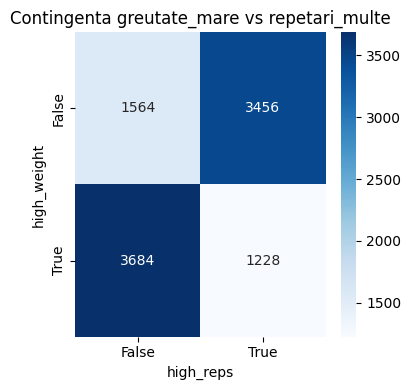

In [38]:
# 3. McNemar test + heatmap tabel de contingenta

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.contingency_tables import mcnemar

# ‚Äî‚Äî‚Äî Cod initial ‚Äî‚Äî‚Äî
# Definim coloane binare
median_weight = df["Weight"].median()
median_reps   = df["Reps"].median()

df["high_weight"] = df["Weight"] > median_weight
df["high_reps"]   = df["Reps"]   > median_reps

# Verificam primele r√¢nduri
print(df[["Weight", "high_weight", "Reps", "high_reps"]].head())

# Tabel de contingenta si McNemar
cont = pd.crosstab(df["high_weight"], df["high_reps"])
print(f"Tabel de contingenta:\n{cont}")

result_mc = mcnemar(cont, exact=True)
print(f"McNemar test: chi2={result_mc.statistic:.4f}, p={result_mc.pvalue:.4f}")

# ‚Äî‚Äî‚Äî Plot adaugat ‚Äî‚Äî‚Äî
plt.figure(figsize=(4,4))
sns.heatmap(cont, annot=True, fmt='d', cmap='Blues')
plt.xlabel('high_reps')
plt.ylabel('high_weight')
plt.title('Contingenta greutate_mare vs repetari_multe')
plt.tight_layout()
plt.show()


- Testul McNemar aratƒÉ o asimetrie semnificativƒÉ √Æn rela»õia dintre greutƒÉ»õile mari »ôi repeti»õiile mari (p<0,01).
- Vizualizarea hƒÉr»õii termice demonstreazƒÉ √Æn mod clar rela»õia inversƒÉ - seturile cu o greutate peste medie au, de obicei, repeti»õii sub medie, confirm√¢nd compromisul for»õƒÉ-rezisten»õƒÉ fundamental pentru principiile antrenamentului cu rezisten»õƒÉ.


### 5. Analiza corelatiilor (Correlation)

#### 5.1 Covarianta  
intrebarea: ‚ÄûCum calculez covarianta intre `Weight` si `Reps`?‚Äù


In [39]:
cov_wr = df["Weight"].cov(df["Reps"])
print(f"Covarianta (Weight, Reps): {cov_wr:.4f}")

Covarianta (Weight, Reps): -137.5606



#### 5.2 Coeficientul de corelatie Pearson


In [40]:
r_wr, p_wr = stats.pearsonr(df["Weight"].dropna(), df["Reps"].dropna())
print(f"Pearson correlation (Weight vs Reps): r={r_wr:.4f}, p={p_wr:.4f}")

Pearson correlation (Weight vs Reps): r=-0.3770, p=0.0000



#### 5.3 Coeficientul de corelatie Spearman


In [41]:
rho_wr, p_rho_wr = stats.spearmanr(df["Weight"].dropna(), df["Reps"].dropna())
print(f"Spearman correlation (Weight vs Reps): œÅ={rho_wr:.4f}, p={p_rho_wr:.4f}")

Spearman correlation (Weight vs Reps): œÅ=-0.4994, p=0.0000



#### 5.4 Coeficientul de corelatie Kendall


In [42]:
tau_wr, p_tau_wr = stats.kendalltau(df["Weight"].dropna(), df["Reps"].dropna())
print(f"Kendall correlation (Weight vs Reps): œÑ={tau_wr:.4f}, p={p_tau_wr:.4f}")

Kendall correlation (Weight vs Reps): œÑ=-0.3776, p=0.0000


- Toate mƒÉsurile de corela»õie aratƒÉ o rela»õie negativƒÉ semnificativƒÉ √Æntre greutate »ôi repeti»õii (r=-0,38, œÅ=-0,50, œÑ=-0,38; toate p<0,0001). 
- Cea mai puternicƒÉ corela»õie apare √Æn coeficientul `Spearman`, suger√¢nd cƒÉ rela»õia este monotonƒÉ, dar nu perfect liniarƒÉ. Acest lucru cuantificƒÉ rela»õia inversƒÉ fundamentalƒÉ dintre sarcinƒÉ »ôi volum √Æn antrenamentul de rezisten»õƒÉ.
--------------------------------------------------------------------------------------------------------------------------


#### 5.5 Chi-square test (pentru variabile categorice)  
intrebarea: ‚ÄûSunt independente variabilele `high_weight` si `high_reps`?‚Äù  


In [43]:
# Tabel de contingenta intre high_weight si high_reps
cont_table = pd.crosstab(df["high_weight"], df["high_reps"])
print(f"Tabel de contingenta:\n{cont_table}")

chi2_c, p_c, dof_c, exp_c = stats.chi2_contingency(cont_table)
print(f"Chi-square test: œá¬≤={chi2_c:.4f}, p={p_c:.4f}, dof={dof_c}")

Tabel de contingenta:
high_reps    False  True 
high_weight              
False         1564   3456
True          3684   1228
Chi-square test: œá¬≤=1913.4700, p=0.0000, dof=1


- Acest test confirmƒÉ o asociere extrem de semnificativƒÉ √Æntre variabilele categorizate de greutate »ôi repeti»õii (œá¬≤=1913,47, p<0,0001). 
- Acest lucru valideazƒÉ √Æn continuare faptul cƒÉ rela»õia inversƒÉ dintre greutate »ôi repeti»õii nu este pur »ôi simplu continuƒÉ, ci rƒÉm√¢ne puternicƒÉ atunci c√¢nd datele sunt clasificate √Æn grupuri mari/scƒÉzute.


## 6. Regresie liniara simpla (Simple Linear Regression)

intrebarea: ‚ÄûPutem prezice `Reps` pornind de la `Weight`?‚Äù  
Vom ajusta un model de tip Y ~ X si vom interpreta coeficientii si statisticile asociate.


                            OLS Regression Results                            
Dep. Variable:                   Reps   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     1645.
Date:                Mon, 09 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:32:40   Log-Likelihood:                -24544.
No. Observations:                9932   AIC:                         4.909e+04
Df Residuals:                    9930   BIC:                         4.911e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.3880      0.051    204.468      0.0

C:\Users\Andrei Balanoiu\AppData\Local\Temp\ipykernel_18404\102344910.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


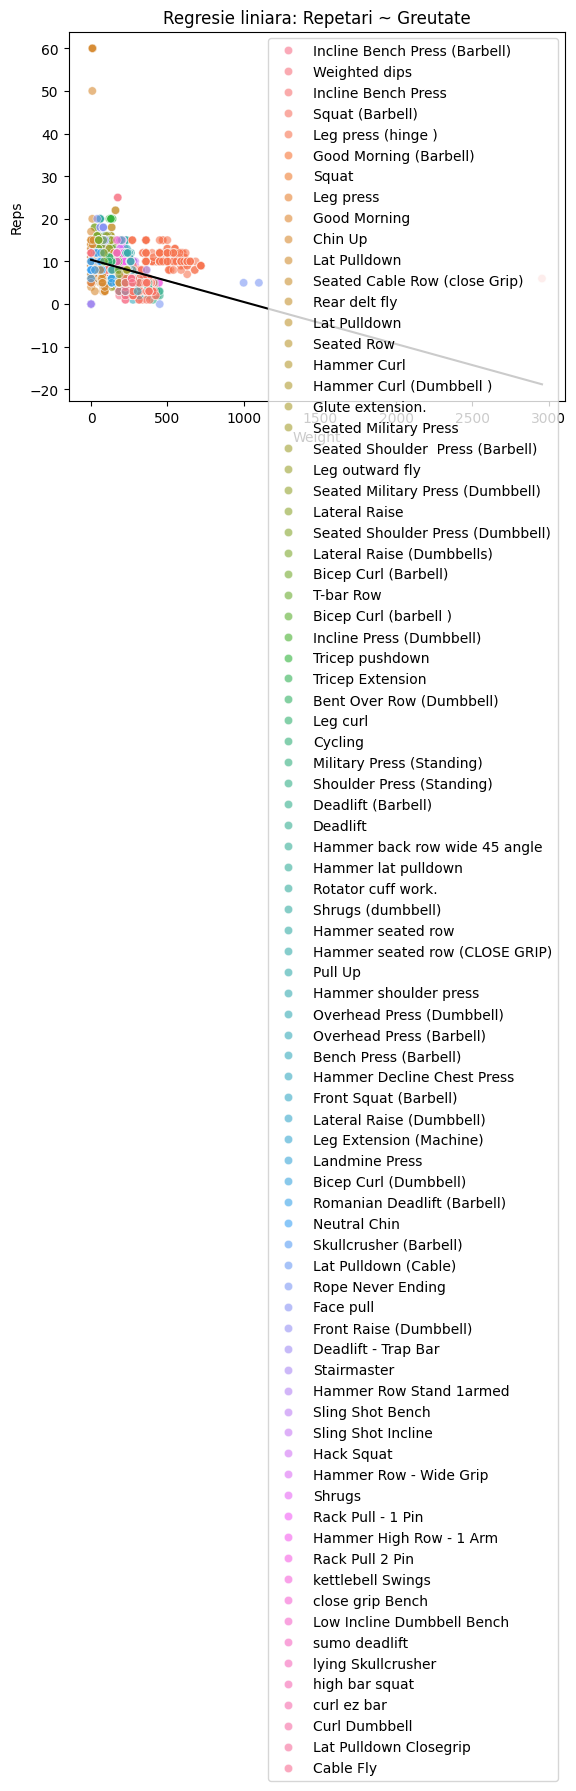

In [44]:
# 5. Regresie liniara simpla (Reps ~ Weight) ‚Äì cod initial deja contine plot

import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# ‚Äî‚Äî‚Äî Cod initial ‚Äî‚Äî‚Äî
model_lr = smf.ols("Reps ~ Weight", data=df).fit()
print(model_lr.summary())

# Plot-ul original
sns.scatterplot(x="Weight", y="Reps", hue="Exercise Name", data=df, alpha=0.6)
sns.lineplot(x=df["Weight"], y=model_lr.predict(df), color="black")
plt.title("Regresie liniara: Repetari ~ Greutate")
plt.tight_layout()
plt.show()


- Modelul de regresie confirmƒÉ cƒÉ greutatea prezice √Æn mod semnificativ repetƒÉrile cu o rela»õie negativƒÉ (Œ≤=-0,03, p<0,0001). 
- Modelul explicƒÉ aproximativ 14% din varia»õia repeti»õiilor (R¬≤ = 0,142), indic√¢nd cƒÉ, √Æn timp ce greutatea este un factor important √Æn determinarea capacitƒÉ»õii de repeti»õie, al»õi factori (cum ar fi tipul de exerci»õiu,somnul,alimentatia,  oboseala, experien»õa de antrenament) influen»õeazƒÉ, de asemenea, √Æn mod substan»õial performan»õa repeti»õiilor.


## 7. Concluzii

- **Statistici descriptive**: 
    - Am obtinut o imagine de ansamblu asupra distributiilor variabilelor (Weight, Reps etc.).  
    - Datele privind ridicarea greutƒÉ»õilor aratƒÉ o varia»õie considerabilƒÉ a parametrilor de antrenament.
    - Greutatea medie utilizatƒÉ este de ~172 lbs, cu o variabilitate ridicatƒÉ (SD=118), √Æn timp ce repeti»õiile sunt √Æn medie de aproximativ 9 pe set. 
    - Majoritatea exerci»õiilor nu implicƒÉ componente de distan»õƒÉ sau de timp (evident din valorile mediane de 0), ceea ce indicƒÉ un antrenament axat mai degrabƒÉ pe for»õƒÉ dec√¢t pe cardio.

- **Distributii**: testele Kolmogorov‚ÄìSmirnov ne-au aratat daca `Weight` si `Reps` respecta normalitatea.  
- **Teste parametrice si neparametrice**: am comparat medii si distributii intre exercitii (t-test, ANOVA vs Mann‚ÄìWhitney, Kruskal‚ÄìWallis etc.), evidentiind diferentele dintre exercitiile populare ('Bench Press', 'Squat', 'Deadlift').  
- **Corelatii**: am cuantificat relatia dintre `Weight` si `Reps` prin Pearson, Spearman si Kendall, si am testat asocierea pentru variabile binarizate (Chi-square).  
- **Regresie liniara**: am construit un model simplu pentru a prezice `Reps` in functie de `Weight` si am evaluat parametrii modelului (coeficientul, p-value si R¬≤).  

